In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# Economic Forecasting using Probabilistic Programming

One issue with applying machine learning algos to 'random' data in the hope of surfacing patterns in the data is that the patterns found may overfit the training set heavily. To combat this, we can use regularization techniques or try to find additional data, however this can be difficult to do.

An alternative approach is to use probabilistic algorithms so we can estimate uncertainty in the forecasts as well as input additional dependencies between variables if we wish.

Using probabilistic programming means that we instead of selecting the hyperparameters using techniques like cross-validation we can model them as latent variables to be learnt. We treat each weight as a distribution - allowing us to sample from them to get a distribution of the output. This is especially handy in cases when you have few data points.

Treating each weight as a distribution in the context of neural nets means that we need to assign priors to each of the variables, input the dependencies between variables and then see how the data and simulations work towards the posterior.

The framework for fitting the model will be variational inference. Essentially this requires minimizing the KL divergence between the input data and the simulated samples.

I have scraped some data from the Bureau of Labor Statistics regarding some of their key indsutries. We can use this data to explore the relationships between these sectors, and in this case I am particularly interested in seeing how easy it is to predict the sales of the Restaurant industry.

The dataset goes from 1992 to early 2020 with a monthly cadence.

In [4]:
data = pd.read_csv('Restaurants.csv')[::-1]
N = 337

In [5]:
data

,DATE,Restaurants_Sales,CPI_Inflation,Grocery_Store_Sales,Clothing_Sales,Sports_Hobbies_Sales,Furniture_Sales,Personal_Care_Sales,Electronics_Sales
337,2/1/2020,4533,259.050,57337,18813,6714,9191,28746,7218
336,1/1/2020,4388,258.820,57495,16612,6698,9257,30047,7736
335,12/1/2019,6630,258.444,57622,34541,6652,11003,33194,11807
334,11/1/2019,5312,257.824,57438,24928,6526,10782,29312,9985
333,10/1/2019,4913,257.229,57201,21177,6764,9995,31088,7604
332,9/1/2019,4680,256.593,57220,19464,6748,9839,28706,7638
331,8/1/2019,5270,256.294,57701,23743,6694,10345,29973,8038
330,7/1/2019,5245,256.087,57692,21650,6703,9944,29508,7669
329,6/1/2019,5011,255.402,57005,20960,6845,9539,28966,7481
328,5/1/2019,5109,255.167,56622,22938,6763,10069,30847,7574


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 337 to 0
Data columns (total 9 columns):
DATE                    338 non-null object
Restaurants_Sales       338 non-null int64
CPI_Inflation           338 non-null float64
Grocery_Store_Sales     338 non-null int64
Clothing_Sales          338 non-null int64
Sports_Hobbies_Sales    338 non-null int64
Furniture_Sales         338 non-null int64
Personal_Care_Sales     338 non-null int64
Electronics_Sales       338 non-null int64
dtypes: float64(1), int64(7), object(1)
memory usage: 23.8+ KB


In [7]:
rest = pd.to_numeric(data.loc[:, 'Restaurants_Sales'][-N:])
cpi = pd.to_numeric(data.loc[:, 'CPI_Inflation'][-N:])
grocery = pd.to_numeric(data.loc[:, 'Grocery_Store_Sales'][-N:])
clothing = pd.to_numeric(data.loc[:, 'Clothing_Sales'][-N:])
sports = pd.to_numeric(data.loc[:, 'Sports_Hobbies_Sales'][-N:])
furniture = pd.to_numeric(data.loc[:, 'Furniture_Sales'][-N:])
personal = pd.to_numeric(data.loc[:, 'Personal_Care_Sales'][-N:])
electronics = pd.to_numeric(data.loc[:, 'Electronics_Sales'][-N:])

rest = rest.pct_change().replace(np.nan, 0).replace(np.inf, 0)
cpi = cpi.pct_change().replace(np.nan, 0).replace(np.inf, 0)
grocery = grocery.pct_change().replace(np.nan, 0).replace(np.inf, 0)
clothing = clothing.pct_change().replace(np.nan, 0).replace(np.inf, 0)
sports = sports.pct_change().replace(np.nan, 0).replace(np.inf, 0)
furniture = furniture.pct_change().replace(np.nan, 0).replace(np.inf, 0)
personal = personal.pct_change().replace(np.nan, 0).replace(np.inf, 0)
electronics = electronics.pct_change().replace(np.nan, 0).replace(np.inf, 0)

rest = np.array(rest)
cpi = np.array(cpi)
grocery = np.array(grocery)
clothing = np.array(clothing)
sports = np.array(sports)
furniture = np.array(furniture)
personal = np.array(personal)
electronics = np.array(electronics)

In [8]:
len(rest)

337

Let's clean the data and visualize the target variable:

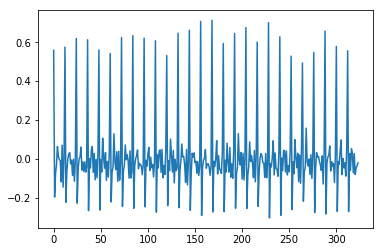

In [9]:
WINDOW = 12
STEP = 1
FORECAST = 1

X, Y = [], []
for i in range(0, len(rest), STEP): 
    try:
        r = rest[i:i+WINDOW]
        inflation = cpi[i:i+WINDOW]
        g = grocery[i:i+WINDOW]
        c = clothing[i:i+WINDOW]
        s = sports[i:i+WINDOW]
        f = furniture[i:i+WINDOW]
        p = personal[i:i+WINDOW]
        elec = electronics[i:i+WINDOW]
        
        y_i = rest[i+WINDOW+FORECAST]
        x_i = np.column_stack((r, inflation, g, c, s, f, p, elec))
        x_i = x_i.flatten()

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)

plt.figure()
plt.plot(Y)
plt.show()

There is clearly a very systematic pattern to sales in the restaurant industry over time - this bodes well for forecasting!

We'll be using the Normal and Bernoulli distributions as priors since they have conjugate priors, and Adam will be used to Optimize the parameters.

In [10]:
import torch
import torch.nn as nn
from torch.nn.functional import normalize  # noqa: F401
import torch.nn.functional as F

from torch.autograd import Variable

import pyro
from pyro.distributions import Normal, Bernoulli  # noqa: F401
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [11]:
pyro.get_param_store().clear()

In [12]:
X_train, Y_train = Variable(torch.Tensor(X[:-12])), Variable(torch.Tensor(Y[:-12]))
X_test, Y_test = Variable(torch.Tensor(X[-12:])), Variable(torch.Tensor(Y[-12:]))

In [13]:
X_train.shape

torch.Size([312, 96])

In [14]:
Y_train.shape

torch.Size([312])

In [15]:
data = torch.cat((X_train, Y_train.unsqueeze(1)), dim=1)

In [16]:
# get array of batch indices
def get_batch_indices(N, batch_size):
    all_batches = np.arange(0, N, batch_size)
    if all_batches[-1] != N:
        all_batches = list(all_batches) + [N]
    return all_batches

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, 1)   # output layer

    def forward(self, x):
        x = self.hidden(x)
        x = self.predict(x)
        return x

first_layer = len(X_train.data.numpy()[0])
second_layer = 25   
    
softplus = nn.Softplus()
regression_model = Net(first_layer, second_layer)

In [17]:
def model(data):

    mu = Variable(torch.zeros(second_layer, first_layer)).type_as(data)
    sigma = Variable(torch.ones(second_layer, first_layer)).type_as(data)
    bias_mu = Variable(torch.zeros(second_layer)).type_as(data)
    bias_sigma = Variable(torch.ones(second_layer)).type_as(data)
    w_prior, b_prior = Normal(mu, sigma), Normal(bias_mu, bias_sigma)
    
    mu2 = Variable(torch.zeros(1, second_layer)).type_as(data)
    sigma2 = Variable(torch.ones(1, second_layer)).type_as(data)
    bias_mu2 = Variable(torch.zeros(1)).type_as(data)
    bias_sigma2 = Variable(torch.ones(1)).type_as(data)
    w_prior2, b_prior2 = Normal(mu2, sigma2), Normal(bias_mu2, bias_sigma2)    
    
    priors = {'hidden.weight': w_prior, 
              'hidden.bias': b_prior,
              'predict.weight': w_prior2,
              'predict.bias': b_prior2}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()

    with pyro.iarange("map", N, subsample=data):
        x_data = data[:, :-1]
        y_data = data[:, -1]
        # run the regressor forward conditioned on inputs
        prediction_mean = lifted_reg_model(x_data).squeeze()
        pyro.sample("obs",
                    Normal(prediction_mean, Variable(torch.ones(data.size(0))).type_as(data)),
                    obs=y_data.squeeze())

def guide(data):
    
    w_mu = Variable(torch.randn(second_layer, first_layer).type_as(data.data), requires_grad=True)
    w_log_sig = Variable((torch.ones(second_layer, first_layer) + 0.05 * torch.randn(second_layer, first_layer)).type_as(data.data), requires_grad=True)
    b_mu = Variable(torch.randn(second_layer).type_as(data.data), requires_grad=True)
    b_log_sig = Variable((torch.ones(second_layer) + 0.05 * torch.randn(second_layer)).type_as(data.data), requires_grad=True)
    
    # register learnable params in the param store
    mw_param = pyro.param("guide_mean_weight", w_mu)
    sw_param = softplus(pyro.param("guide_log_sigma_weight", w_log_sig))
    mb_param = pyro.param("guide_mean_bias", b_mu)
    sb_param = softplus(pyro.param("guide_log_sigma_bias", b_log_sig))
    
    # gaussian guide distributions for w and b
    w_dist = Normal(mw_param, sw_param)
    b_dist = Normal(mb_param, sb_param)
    
    w_mu2 = Variable(torch.randn(1, second_layer).type_as(data.data), requires_grad=True)
    w_log_sig2 = Variable((torch.ones(1, second_layer) + 0.05 * torch.randn(1, second_layer)).type_as(data.data), requires_grad=True)
    b_mu2 = Variable(torch.randn(1).type_as(data.data), requires_grad=True)
    b_log_sig2 = Variable((torch.ones(1) + 0.05 * torch.randn(1)).type_as(data.data), requires_grad=True)
    
    
    
    # register learnable params in the param store
    mw_param2 = pyro.param("guide_mean_weight2", w_mu2)
    sw_param2 = softplus(pyro.param("guide_log_sigma_weight2", w_log_sig2))
    mb_param2 = pyro.param("guide_mean_bias2", b_mu2)
    sb_param2 = softplus(pyro.param("guide_log_sigma_bias2", b_log_sig2))
    
    # gaussian guide distributions for w and b
    w_dist2 = Normal(mw_param2, sw_param2)
    b_dist2 = Normal(mb_param2, sb_param2)
      
    dists = {'hidden.weight': w_dist, 
              'hidden.bias': b_dist,
              'predict.weight': w_dist2,
              'predict.bias': b_dist2}
    
    # overloading the parameters in the module with random samples from the guide distributions
    lifted_module = pyro.random_module("module", regression_model, dists)
    # sample a regressor
    return lifted_module()

In [18]:
model(data)
guide(data)

Net(
  (hidden): Linear(in_features=96, out_features=25, bias=True)
  (predict): Linear(in_features=25, out_features=1, bias=True)
)

In [19]:
# instantiate optim and inference objects
optim = Adam({"lr": 0.001})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

N = len(X_train.data.numpy())

for j in range(10000):
    epoch_loss = 0.0
    perm = torch.randperm(N)
    # shuffle data
    data = data[perm]
    # get indices of each batch
    all_batches = get_batch_indices(N, 64)
    for ix, batch_start in enumerate(all_batches[:-1]):
        batch_end = all_batches[ix + 1]
        batch_data = data[batch_start: batch_end]        
        epoch_loss += svi.step(batch_data)
    if j % 100 == 0:
        print("epoch avg loss {}".format(epoch_loss/float(N)))

epoch avg loss 1515.559264393571
epoch avg loss 1281.009654714893
epoch avg loss 732.8018565382331
epoch avg loss 647.4981870357043
epoch avg loss 374.06197761954405
epoch avg loss 399.72878498927906
epoch avg loss 530.4253773725568
epoch avg loss 303.24294050056966
epoch avg loss 211.17446942799367
epoch avg loss 191.42514337274508
epoch avg loss 137.85409992035383
epoch avg loss 148.3856386389488
epoch avg loss 153.71334039954803
epoch avg loss 89.27805964744243
epoch avg loss 70.5890472070911
epoch avg loss 48.529255182888264
epoch avg loss 64.96261919652804
epoch avg loss 49.48993252943723
epoch avg loss 38.742030177360924
epoch avg loss 36.46385024373348
epoch avg loss 30.828782403507294
epoch avg loss 25.839980117594585
epoch avg loss 20.369010664522648
epoch avg loss 19.520096368896656
epoch avg loss 20.446461151998776
epoch avg loss 13.517944628229507
epoch avg loss 15.308027475881271
epoch avg loss 11.802604208389917
epoch avg loss 10.425825021969967
epoch avg loss 11.56691413

In [20]:
y_preds = Variable(torch.zeros(12, 1))
for i in range(100):
    sampled_reg_model = guide(X_test)
    # run the regression model and add prediction to total
    y_preds = y_preds + sampled_reg_model(X_test)
# take the average of the predictions
y_preds = y_preds / 100

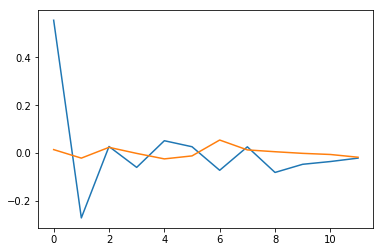

In [21]:
plt.figure()
plt.plot(Y_test.data.numpy())
plt.plot(y_preds.data.numpy())
plt.show()

In [22]:
torch.mean(y_preds)

tensor(0.0027, grad_fn=<MeanBackward0>)

A MAPE of less than 2% over the 12 month forecast horizon. This is potentially promising and probably points to extent to which forces in the broader economy drive Sales as well as sector specifics.